### 1. CPU 및 GPU 환경설정

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri Dec 16 04:42:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  CUDA GPU            On   | 00000000:E1:00.0 Off |                  Off |
| 30%   23C    P0    60W / 230W |     48MiB / 24564MiB |      0%      Default |
|                               |            

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

In [3]:
CFG = {
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':64,
    'SEED':42
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 2. 데이터셋

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.shape, test.shape

((16541, 7), (7090, 2))

In [6]:
train.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [7]:
len(train), len(train['문장'].drop_duplicates()) # 중복문장 존재

(16541, 16506)

In [9]:
train['유형'].nunique(), train['극성'].nunique(), train['시제'].nunique(), train['확실성'].nunique()

(4, 3, 3, 2)

### 3. 허깅페이스 트랜스포머 설치

In [8]:
#!pip install -q transformers

### 4. EDA

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
texts_len = [len(x) for x in train['문장']]

In [13]:
min(texts_len), max(texts_len), np.mean(texts_len)

(7, 534, 63.8257058218971)

**4.1 문장의 길이의 히스토그램**

Text(0, 0.5, 'Probability')

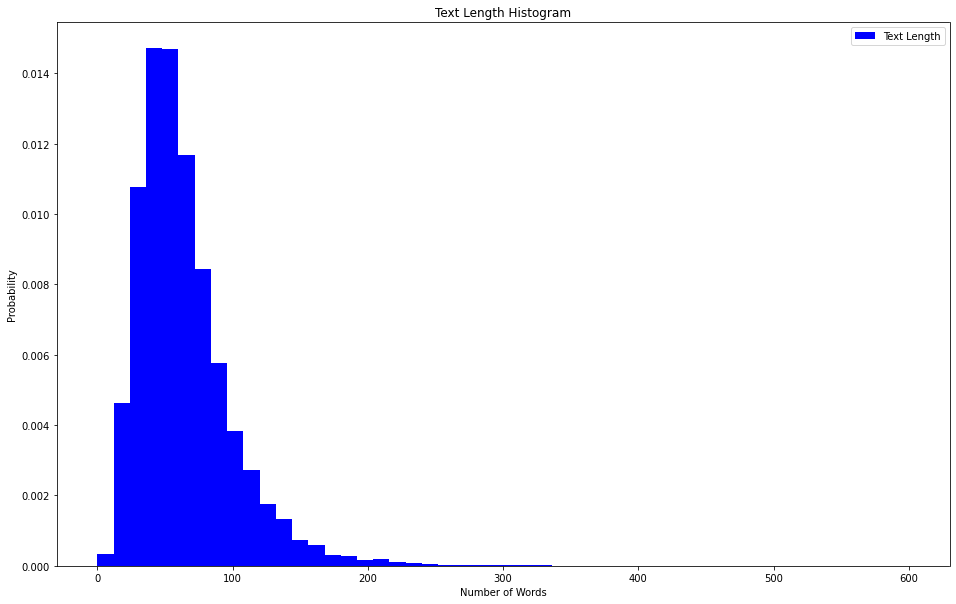

In [31]:
plt.figure(figsize=(16, 10))
plt.hist(texts_len, bins=50, range=[0, 600], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

**4.2 각 태그별 데이터에 포함된 갯수**

In [15]:
train['유형'].value_counts()

사실형    13558
추론형     2151
대화형      575
예측형      257
Name: 유형, dtype: int64

### 5. Train Test Split

In [16]:
from sklearn.model_selection import train_test_split
train, val, _, _ = train_test_split(train, train['label'], test_size=.15, random_state=42)

In [17]:
train.shape, val.shape

((14059, 7), (2482, 7))

In [18]:
# print('Train 문장 : {:>6,}' .format(len(x_train)))
# print('Train 태그 : {:>6,}' .format(len(y_train)))
# print('Test  문장 : {:>6,}' .format(len(x_valid)))
# print('Test  태그 : {:>6,}' .format(len(y_valid)))

In [19]:
from sklearn.preprocessing import LabelEncoder

type_le = LabelEncoder()
train["유형"] = type_le.fit_transform(train["유형"].values)
val["유형"] = type_le.transform(val["유형"].values)

polarity_le = LabelEncoder()
train["극성"] = polarity_le.fit_transform(train["극성"].values)
val["극성"] = polarity_le.transform(val["극성"].values)

tense_le = LabelEncoder()
train["시제"] = tense_le.fit_transform(train["시제"].values)
val["시제"] = tense_le.transform(val["시제"].values)

certainty_le = LabelEncoder()
train["확실성"] = certainty_le.fit_transform(train["확실성"].values)
val["확실성"] = certainty_le.transform(val["확실성"].values)

In [20]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

### 6. 토크나이저

In [21]:
from transformers import AutoModel, AutoTokenizer
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [35]:
class CustomDataset(Dataset):
  
  def __init__(self, texts, labels, tokenizer):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    inputs = self.tokenizer(
        self.texts[idx], 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    
    if self.labels is not None:
        label = self.labels[idx]
        return input_ids, attention_mask, label
    else:
        return input_ids, attention_mask

In [23]:
train_dataset = CustomDataset(train['문장'], train['유형'], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['문장'], val['유형'], tokenizer)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 7. Train

In [24]:
# def train(model, optimizer, train_loader, val_loader, scheduler, device):
#     model.to(device)
    
#     criterion = {
#         'type' : nn.CrossEntropyLoss().to(device),
#         'polarity' : nn.CrossEntropyLoss().to(device),
#         'tense' : nn.CrossEntropyLoss().to(device),
#         'certainty' : nn.CrossEntropyLoss().to(device)
#     }
    
#     best_loss = 999999
#     best_model = None
    
#     for epoch in range(1, CFG['EPOCHS']+1):
#         model.train()
#         train_loss = []
#         for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(train_loader)):
#             sentence = sentence.to(device)
#             type_label = type_label.to(device)
#             polarity_label = polarity_label.to(device)
#             tense_label = tense_label.to(device)
#             certainty_label = certainty_label.to(device)
            
#             optimizer.zero_grad()
            
#             type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence)
            
#             loss = 0.25 * criterion['type'](type_logit, type_label) + \
#                     0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
#                     0.25 * criterion['tense'](tense_logit, tense_label) + \
#                     0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
#             loss.backward()
#             optimizer.step()
            
#             train_loss.append(loss.item())
        
#         val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1 = validation(model, val_loader, criterion, device)
#         print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}] 극성 F1 : [{val_polarity_f1:.5f}] 시제 F1 : [{val_tense_f1:.5f}] 확실성 F1 : [{val_certainty_f1:.5f}]')
        
#         if scheduler is not None:
#             scheduler.step(val_loss)
            
#         if best_loss > val_loss:
#             best_loss = val_loss
#             best_model = model
            
#     return best_model

In [25]:
# def validation(model, val_loader, criterion, device):
#     model.eval()
#     val_loss = []
    
#     type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
#     type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
#     with torch.no_grad():
#         for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(val_loader)):
#             sentence = sentence.to(device)
#             type_label = type_label.to(device)
#             polarity_label = polarity_label.to(device)
#             tense_label = tense_label.to(device)
#             certainty_label = certainty_label.to(device)
            
#             type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence)
            
#             loss = 0.25 * criterion['type'](type_logit, type_label) + \
#                     0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
#                     0.25 * criterion['tense'](tense_logit, tense_label) + \
#                     0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
#             val_loss.append(loss.item())
            
#             type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
#             type_labels += type_label.detach().cpu().numpy().tolist()
            
#             polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
#             polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
#             tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
#             tense_labels += tense_label.detach().cpu().numpy().tolist()
            
#             certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
#             certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
#     type_f1 = f1_score(type_labels, type_preds, average='weighted')
#     polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
#     tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
#     certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
    
#     return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1

In [26]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    criterion = {'type' : nn.CrossEntropyLoss().to(device)}
    
    best_loss = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for input_ids_batch, attention_masks_batch, y_batch in tqdm(iter(train_loader)):
            y_batch = y_batch.to(device)
            y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
#             polarity_label = polarity_label.to(device)
#             tense_label = tense_label.to(device)
#             certainty_label = certainty_label.to(device)
            
            optimizer.zero_grad()
            
            #type_logit = model(sentence)
            
            loss = criterion['type'](y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_type_f1 = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            
    return best_model

In [27]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds = []
    type_labels = []
    
    
    with torch.no_grad():
        for input_ids_batch, attention_masks_batch, y_batch in tqdm(iter(val_loader)):
            y_batch = y_batch.to(device)
            y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
#             polarity_label = polarity_label.to(device)
#             tense_label = tense_label.to(device)
#             certainty_label = certainty_label.to(device)
            
            #type_logit = model(sentence)
            
            loss = criterion['type'](y_pred, y_batch)
            val_loss.append(loss.item())
            
            type_preds += y_pred.argmax(1).detach().cpu().numpy().tolist()
            type_labels += y_batch.detach().cpu().numpy().tolist()
            
#             polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
#             polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
#             tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
#             tense_labels += tense_label.detach().cpu().numpy().tolist()
            
#             certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
#             certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
#     polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
#     tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
#     certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
    
    return np.mean(val_loss), type_f1#, polarity_f1, tense_f1, certainty_f1

In [28]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
model.eval()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [29]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.42031] Val Loss : [0.28846] 유형 F1 : [0.86147]


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.25386] Val Loss : [0.26605] 유형 F1 : [0.89540]


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.17297] Val Loss : [0.30424] 유형 F1 : [0.89303]


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.11728] Val Loss : [0.33294] 유형 F1 : [0.89011]


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.08839] Val Loss : [0.40538] 유형 F1 : [0.88556]
Epoch     5: reducing learning rate of group 0 to 5.0000e-05.


### 8. Inference

In [36]:
test_dataset = CustomDataset(test['문장'], None, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [40]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    #type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_preds = []
    
    with torch.no_grad():
        for input_ids_batch, attention_masks_batch in tqdm(test_loader):            
            type_logit = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
#             polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
#             tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
#             certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            
    return type_preds#, polarity_preds, tense_preds, certainty_preds

In [41]:
#type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, test_loader, device)

In [53]:
type_preds = inference(infer_model, test_loader, device)

  0%|          | 0/111 [00:00<?, ?it/s]

In [54]:
type_preds = type_le.inverse_transform(type_preds)
# polarity_preds = polarity_le.inverse_transform(polarity_preds)
# tense_preds = tense_le.inverse_transform(tense_preds)
# certainty_preds = certainty_le.inverse_transform(certainty_preds)

In [ ]:
# predictions = []
# for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
#     predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

### 9. Submission

In [47]:
# submit = pd.read_csv('data/sample_submission.csv')
# submit['label'] = predictions

In [55]:
submit = pd.read_csv('submission/baseline_1216.csv')
submit.head()

,ID,label,type
0,TEST_0000,추론형-긍정-현재-확실,사실형
1,TEST_0001,추론형-긍정-현재-확실,사실형
2,TEST_0002,추론형-긍정-현재-확실,사실형
3,TEST_0003,추론형-긍정-현재-확실,사실형
4,TEST_0004,추론형-긍정-현재-확실,사실형


In [59]:
submit['type'] = type_preds

In [60]:
submit.head()

,ID,label,type
0,TEST_0000,추론형-긍정-현재-확실,사실형
1,TEST_0001,추론형-긍정-현재-확실,사실형
2,TEST_0002,추론형-긍정-현재-확실,사실형
3,TEST_0003,추론형-긍정-현재-확실,사실형
4,TEST_0004,추론형-긍정-현재-확실,사실형


In [61]:
submit['type'].value_counts()

사실형    5938
추론형     787
대화형     263
예측형     102
Name: type, dtype: int64

In [51]:
submit.to_csv('submission/baseline_1216.csv', index=False)

In [ ]:
#submit.to_csv('submission/baseline_1216.csv', index=False)